# Comparison of BrainAges

Comparison of BrainAge deltas for discrimiantion between stable MCI and progressive MCI. These BrainAges are based on structural brain data and neuropsych test. These are also compared to using features directly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

In [2]:
# Load data
df = pd.read_csv('../DATA/adni_brainage.csv', index_col=0)
df_smci = df[df['TYPECONVERSOR']==2.0]
df_pmci = df[df['TYPECONVERSOR']==5.0]

# Merge with all features
df_full = pd.read_csv('../DATA/adni_full_data.csv', index_col=0)
df_smci = df_smci.merge(df_full, on=['RID', 'TYPECONVERSOR'])
df_pmci= df_pmci.merge(df_full, on=['RID', 'TYPECONVERSOR'])

#Subsample to balance
df_smci = df_smci.sample(n=len(df_pmci), random_state=0)

#TODO time to conversion

# Create labels
Y_smci = np.zeros(len(df_pmci))
Y_pmci = np.ones(len(df_smci))
Y = np.concatenate([Y_smci, Y_pmci])

#Threhsold to binarize predictions
thr = 0.5 

def plot_roc(X, Y, name):
    
    #instantiate the model
    log_regression = LogisticRegression()

    #fit the model using the training data
    log_regression.fit(X,Y)

    #use model to predict probability that given y value is 1
    y_pred = log_regression.predict_proba(X)[::,1]

    #calculate AUC of model
    auc = roc_auc_score(Y, y_pred)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, thrs= roc_curve(Y, y_pred)
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.3f)" % auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC %s" % name)
    plt.legend(loc="lower right")
    
    # Calculate relevant metrics
    acc = accuracy_score(Y, y_pred>thr)
    tn, fp, fn, tp = confusion_matrix(Y, y_pred>thr).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fp)
    plt.text(0.55, 0.3, ' Accuracy: %.3f \n Sensitivity: %.3f \n Specificity %.3f' % 
                         (acc, sensitivity, specificity), fontsize=12)

### Comparison of deltas

We use the deltas calculated for each subject to train a logistic regressor to distinguish between sMCI and pMCI. We use structuralBrainDelta and neuroBrainDelta seperately, adding them and using them as individual features.

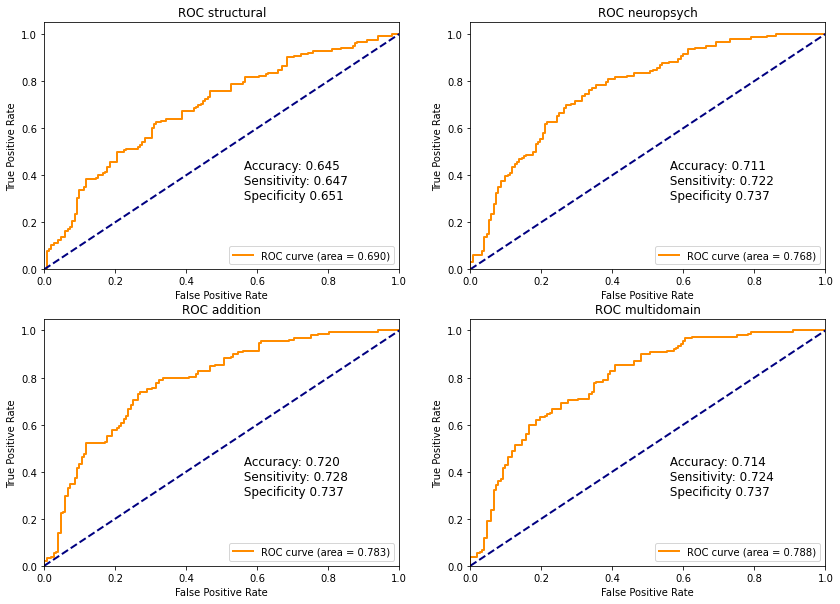

In [3]:
# Load structural
X_smci_struc = df_smci['StructBrainDelta'].to_numpy()
X_pmci_struc = df_pmci['StructBrainDelta'].to_numpy()
X_struc = np.concatenate([X_smci_struc, X_pmci_struc]).reshape(-1, 1)

# Load neuro
X_smci_neuro = df_smci['NeuroBrainDelta'].to_numpy()
X_pmci_neuro = df_pmci['NeuroBrainDelta'].to_numpy()
X_neuro = np.concatenate([X_smci_neuro, X_pmci_neuro]).reshape(-1, 1)

# Add both features
X_smci_add = X_smci_struc + X_smci_neuro
X_pmci_add = X_pmci_struc + X_pmci_neuro
X_add = np.concatenate([X_smci_add, X_pmci_add]).reshape(-1, 1)

# Join both features
X_smci_multi = np.stack([X_smci_struc, X_smci_neuro], axis=1)
X_pmci_multi = np.stack([X_pmci_struc, X_pmci_neuro], axis=1)
X_multi = np.concatenate([X_smci_multi, X_pmci_multi], axis=0)


# Run each through logistic regressor
names = ['structural', 'neuropsych', 'addition', 'multidomain']
Xs = [X_struc, X_neuro, X_add, X_multi]
plt.figure(figsize=(14,10))
for i, X in enumerate(Xs):
    plt.subplot(2,2,i+1)
    plot_roc(X, Y, names[i])
plt.show()

### Using features

Train a logistic regressor based on structural and neurpysch features directly.

In [4]:
# Features to use
f_neuro = ['MMSCORE', 'ADASSCORE', 'FAQTOTAL', 'MOCASCORE', 'ADNI_MEM', 'ADNI_EF']
f_struc = ['GM', 'WM', 'vscf', 'pgrey', 
        'Thalmus', 'Caudate', 'Putamen', 'Palidum', 
        'Hippo', 'Amygdala', 'Accumbens', 'Brainstem']
f_all = [*f_struc, *f_neuro]

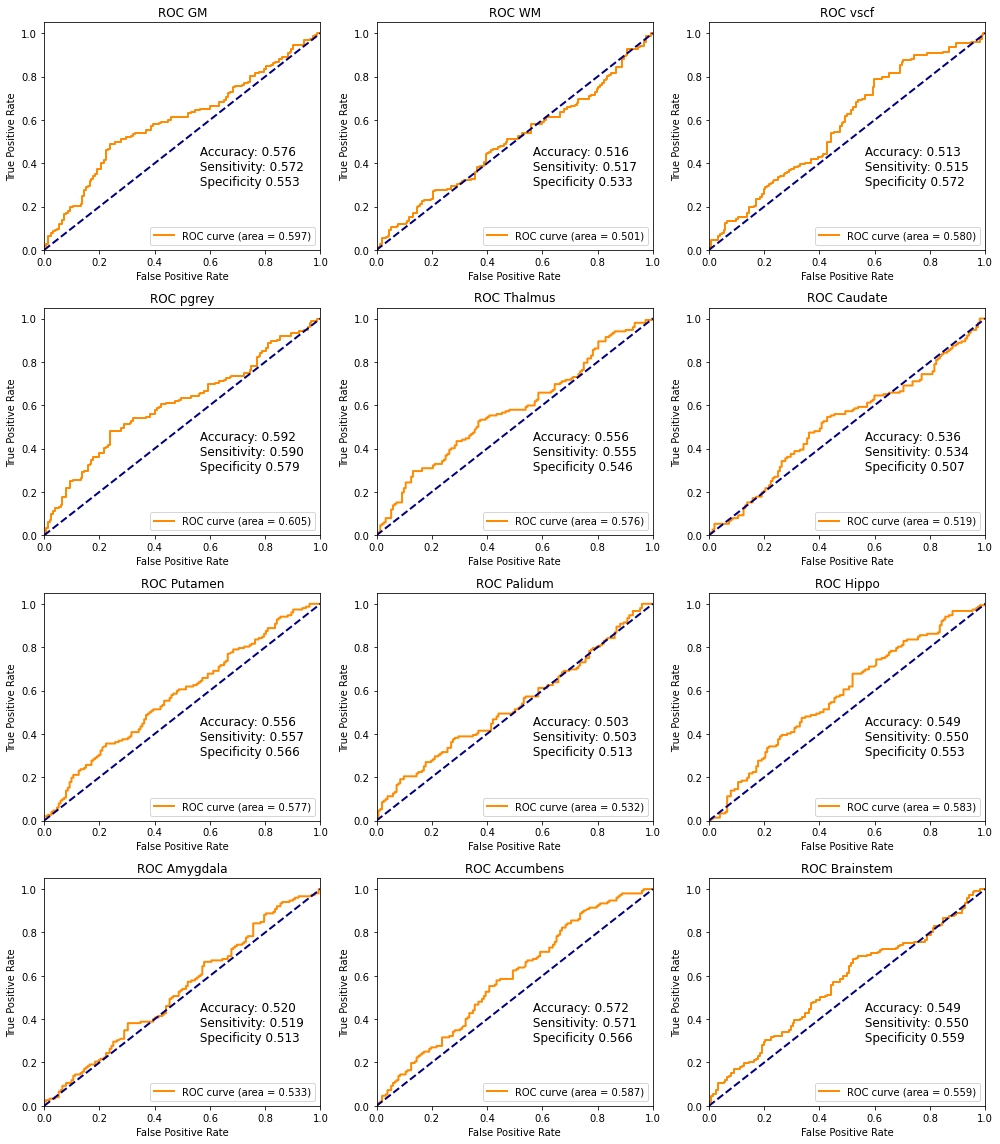

In [5]:
# Individual preidcitve power of each structural feature
plt.figure(figsize=(14,16))
for i, f in enumerate(f_struc):
    plt.subplot(4,3,i+1)
    
    # Concatenate data
    X_smci = df_smci[f]
    X_pmci = df_pmci[f]
    X = np.concatenate([X_smci, X_pmci]).reshape(-1, 1)
    
    # Apply scaler to features
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    # Plot ROC
    plot_roc(X, Y, f)
    
plt.tight_layout()
plt.show()

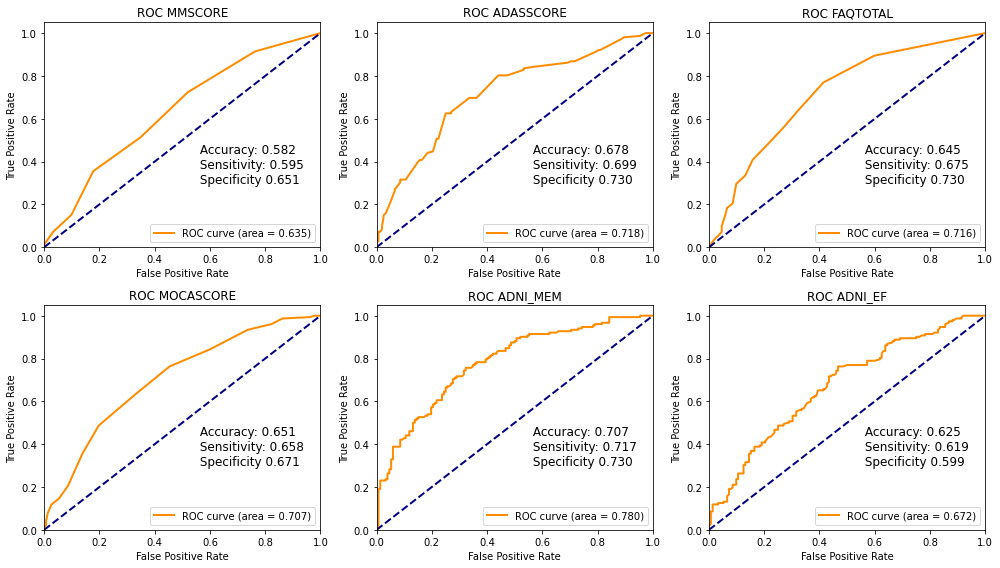

In [6]:
# Individual preidcitve power of each neuropsych feature
plt.figure(figsize=(14,8))
for i, f in enumerate(f_neuro):
    plt.subplot(2,3,i+1)
    
    # Concatenate data
    X_smci = df_smci[f]
    X_pmci = df_pmci[f]
    X = np.concatenate([X_smci, X_pmci]).reshape(-1, 1)
    
    # Apply scaler to features
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    # Plot ROC
    plot_roc(X, Y, f)
    
plt.tight_layout()
plt.show()

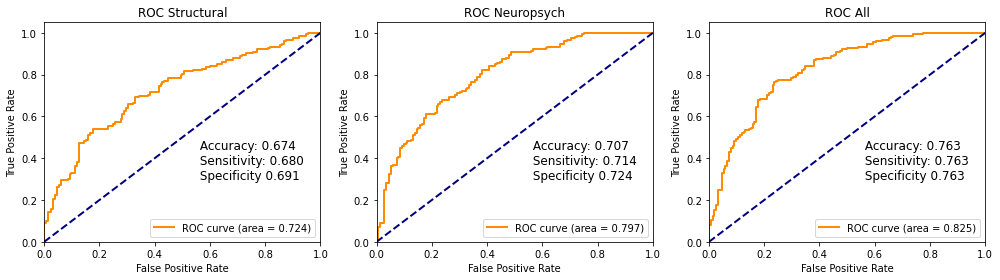

In [7]:
# Run through possible combinations
features = [f_struc, f_neuro, f_all]
names = ['Structural', 'Neuropsych', 'All']
plt.figure(figsize=(14,4))
for i, f in enumerate(features):
    plt.subplot(1,3,i+1)
    
    # Concatenate data
    X_smci = df_smci[f]
    X_pmci = df_pmci[f]
    X = np.concatenate([X_smci, X_pmci])
    
    # Apply scaler to features
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    # Plot ROC
    plot_roc(X, Y, names[i])

plt.tight_layout()
plt.show()